# Weather forecast in Germany

This notebook implements a deep learning network to work on time series data. This is an adoptation of my another notebook where I implemented a RNN to predict weather forecast in Wiesbaden, Germany. Here I used the same data, just the network is a deep learning network instead of RNN. The network is implemented using Tensorflow where that other RNN network was implemented in Keras. The other notebook can be found [here][1].

[1]: https://github.com/moshfiqur/aparecium/blob/master/german-weather-forecast/german-weather-forecast.ipynb

This notebook was adopted from [Hvass-Labs][2]'s tensorflow tutorial. The deep learning network was inspired from this blog of [Sebastian Heinz][3].

[2]: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb
[3]: https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877

In this notebook, we will try to predict weather for near future. For testing, I am going to use weather data collected for the city Wiesbaden, as I live here now.

The data is collected from [Climate Data Center (CDC)][2] of Deutscher Wetterdienst.

[2]: https://cdc.dwd.de/portal/201804271017/index.html

Data can be downloaded from this [ftp server][3].

[3]: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/historical/


Check out this [PDF][4] for dataset description.

[4]: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/historical/DESCRIPTION_obsgermany_climate_hourly_tu_historical_en.pdf

### Import Modules

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

### Define the Paths

In [3]:
ROOT_DIR = '/Users/sparrow/Learning/machine-learning/aparecium/german-weather-forecast'
MODEL_DIR = os.path.join(ROOT_DIR, 'models')
DATASET_DIR = '/srv/downloads/moshfiqur-ml-datasets/aparecium/german-weather-forecast'

### Load Data

The weather information data is distributed by station. The list of stations and other related data can be found [here][4].

[4]: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/historical/TU_Stundenwerte_Beschreibung_Stationen.txt

The station ID for Wiesbaden is 05541. So, I downloaded the data for [Wiesbaden][5].

[5]: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/historical/stundenwerte_TU_05541_20040801_20171231_hist.zip

In [4]:
station_id = '05541'
date_from = 20040801
date_to = 20171231
total_data_rows = 263
station_lat = 50.1320
station_lon = 8.3170
station_name = 'Wiesbaden-Auringen'
station_state = 'Hessen'

data_folder = 'stundenwerte_TU_{}_{}_{}_hist'.format(station_id, date_from, date_to)
data_file = 'produkt_tu_stunde_{}_{}_{}.txt'.format(date_from, date_to, station_id)


In [5]:
df = pd.read_csv(os.path.join(DATASET_DIR, data_folder, data_file), delimiter=';')
df.head()

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
0,5541,2004080100,3,19.3,71.0,eor
1,5541,2004080101,10,18.5,75.0,eor
2,5541,2004080102,10,17.8,78.0,eor
3,5541,2004080103,10,17.8,78.0,eor
4,5541,2004080104,10,17.7,78.0,eor


### Data Cleanup

Data info:
```
STATIONS_ID = Station ID
MESS_DATUM = Messurement time, in yyyymmddhh format
QN_9 = Quality level of next columns
TT_TU = 2m air temperature, in degree celcius
RF_TU = 2m relative humidity, in %
eor = End of record
```

#### Convert MESS_DATUM to DateTiime format and save to a column

In [6]:
df['DATE_TIME'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H')
# df.sort_values(['DATE_TIME'])
df.tail()

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor,DATE_TIME
117401,5541,2017123119,3,9.1,82.0,eor,2017-12-31 19:00:00
117402,5541,2017123120,3,9.4,80.0,eor,2017-12-31 20:00:00
117403,5541,2017123121,3,9.3,79.0,eor,2017-12-31 21:00:00
117404,5541,2017123122,3,9.1,79.0,eor,2017-12-31 22:00:00
117405,5541,2017123123,3,9.9,77.0,eor,2017-12-31 23:00:00


#### Set the DATE_TIME as index

In [7]:
df.set_index('DATE_TIME', inplace=True)
df.tail()

,STATIONS_ID,MESS_DATUM,QN_9,TT_TU,RF_TU,eor
DATE_TIME,,,,,,
2017-12-31 19:00:00,5541,2017123119,3,9.1,82.0,eor
2017-12-31 20:00:00,5541,2017123120,3,9.4,80.0,eor
2017-12-31 21:00:00,5541,2017123121,3,9.3,79.0,eor
2017-12-31 22:00:00,5541,2017123122,3,9.1,79.0,eor
2017-12-31 23:00:00,5541,2017123123,3,9.9,77.0,eor


#### Drop unnecessary columns

In [8]:

df.drop(['MESS_DATUM', 'STATIONS_ID', 'QN_9', 'eor'], inplace=True, axis=1)

#### Plot the temperature data 
There are some error in the data. As we see below, there are two data instance where temperature went almost to -1000 degree celcius which is impossible.

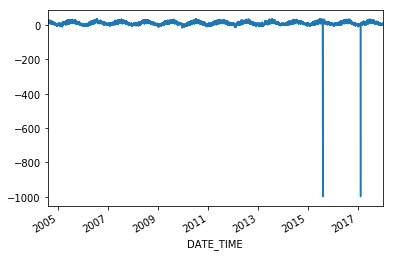

In [9]:
df['TT_TU'].plot()

#### Plot the humidity data
There are some errors in humidity data as well as there are 3 instances of data which contains negative value for humidity which is not possible

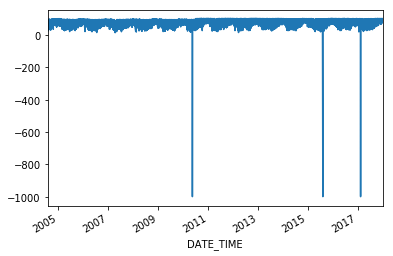

In [10]:
df['RF_TU'].plot()

#### Overview of the problematic data

In [11]:
df.loc[(df['RF_TU'] < -50) | (df['TT_TU'] < -50)].head()

,TT_TU,RF_TU
DATE_TIME,,
2010-05-20 04:00:00,8.1,-999.0
2015-08-11 13:00:00,-999.0,-999.0
2017-02-12 13:00:00,-999.0,-999.0
2017-02-12 14:00:00,-999.0,-999.0
2017-02-12 15:00:00,-999.0,-999.0


#### Perform LOCF (Last Observation Carried Forward) to fix bad data

In [12]:
# First replace the bad data with NaN
df.loc[df['RF_TU'] < -50, 'RF_TU'] = np.NaN
df.loc[df['TT_TU'] < -50, 'TT_TU'] = np.NaN

# Then perform a forward fill
df.fillna(method='ffill', inplace=True)

#### Plot data after fixing

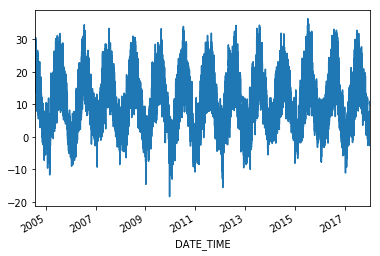

In [13]:
df['TT_TU'].plot()

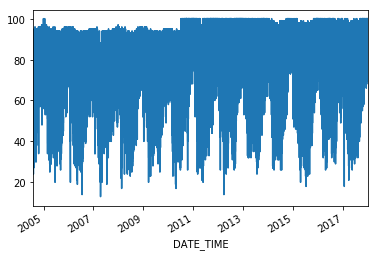

In [14]:
df['RF_TU'].plot()

### Data Preparation

The dataset has observation for each hour, so there are 24 observations in a day. We want to predict the weather 24 hours in the future. So, we shift the data 24 times in the future. For one week, the shift steps would be 7 * 24. 

In [15]:
shift_days = 1
shift_steps = shift_days * 24

Create a new dataframe with the time shifted data. To shift the data in future direction, we must shift it with negative direction. 

The shifted data-frame is confusing because Pandas keeps the original time-stamps even though we have shifted the data. You can check the time-shift is correct by comparing the original and time-shifted dataframes.

In [16]:
df_shifted = df[['TT_TU', 'RF_TU']].shift(-shift_steps)

The first `shift_steps + 5` rows of the original dataframe 

In [17]:
df.head(shift_steps + 5)

,TT_TU,RF_TU
DATE_TIME,,
2004-08-01 00:00:00,19.3,71.0
2004-08-01 01:00:00,18.5,75.0
2004-08-01 02:00:00,17.8,78.0
2004-08-01 03:00:00,17.8,78.0
2004-08-01 04:00:00,17.7,78.0
2004-08-01 05:00:00,17.6,80.0
2004-08-01 06:00:00,18.8,74.0
2004-08-01 07:00:00,20.6,68.0
2004-08-01 08:00:00,22.5,58.0


In [18]:
df.tail(5)

,TT_TU,RF_TU
DATE_TIME,,
2017-12-31 19:00:00,9.1,82.0
2017-12-31 20:00:00,9.4,80.0
2017-12-31 21:00:00,9.3,79.0
2017-12-31 22:00:00,9.1,79.0
2017-12-31 23:00:00,9.9,77.0


The following is the first 5 rows of the time shifted dataframe. This should be identical to the last 5 rows shown above from the original data, except for the timestamp.

In [19]:
df_shifted.head(5)

,TT_TU,RF_TU
DATE_TIME,,
2004-08-01 00:00:00,17.7,69.0
2004-08-01 01:00:00,17.4,71.0
2004-08-01 02:00:00,16.4,72.0
2004-08-01 03:00:00,16.9,70.0
2004-08-01 04:00:00,16.5,73.0


The time shifted dataframe has the same length as the original dataframe, except the last `shift_steps` rows has Nan. Because we shifted the data backwards, hence those rows does not contain any data.

In [20]:
df_shifted.tail()

,TT_TU,RF_TU
DATE_TIME,,
2017-12-31 19:00:00,NaN,NaN
2017-12-31 20:00:00,NaN,NaN
2017-12-31 21:00:00,NaN,NaN
2017-12-31 22:00:00,NaN,NaN
2017-12-31 23:00:00,NaN,NaN


We will now convert the pandas dataframe into numpy arrays so that it can be input into the neural network. We will not consider the last `shift_steps` number of rows in the original dataframe. Because, in the shifted dataframe, those rows contains NaN. Those NaN will produce errors as they are not valid data. Also, we need to have same shape for input and output data.

In [21]:
df.shape, df_shifted.shape

((117406, 2), (117406, 2))

In [22]:
target_names = ['TT_TU', 'RF_TU']

# Training data
data_train = df.values[0:-shift_steps]

# Testing data
data_target = df_shifted.values[0:-shift_steps]

data_train.shape, data_target.shape

((117382, 2), (117382, 2))

In [23]:
df.values.shape, shift_steps, type(df.values)

((117406, 2), 24, numpy.ndarray)

In [24]:
# Number of observations
num_data = len(data_train)

# Percentage of dataset that will be used for training
train_split = 0.8

# Number of observations in the training set
num_train = int(train_split * num_data)

# Number of observation in the test set
num_test = num_data - num_train

# Samples for train and test dataset
X_train_orig = data_train[0:num_train]
X_test_orig = data_train[num_train:]

y_train_orig = data_target[0:num_train]
y_test_orig = data_target[num_train:]

X_train_orig.shape, y_train_orig.shape, X_test_orig.shape, y_test_orig.shape

((93905, 2), (93905, 2), (23477, 2), (23477, 2))

In [25]:
# number of input values
# 2, one for temperature and 
# another for humidity
# TODO should be input_shape
input_shape = X_train_orig.shape[1]

# number of output values
# 2, one for temperature and 
# another for humidity
# TODO should be output_shape
output_shape = y_train_orig.shape[1]

input_shape, output_shape

(2, 2)

### Data Normalization

In [26]:
print('Min:', np.min(X_train_orig))
print('Max:', np.max(X_train_orig))

Min: -18.5
Max: 100.0


As we can see from above, the dataset contains a wide range of values. Neural network works best on values ranges between -1 to 1. So, we need to scale the data before it is being input to the neural network.

In [27]:
x_scaler = MinMaxScaler(feature_range=(-1, 1))

# Detect the range of values from the training dataset
# and scale the training data.
X_train = x_scaler.fit_transform(X_train_orig)

# Use the same scaler to scale the test dataset
X_test = x_scaler.transform(X_test_orig)

In [28]:
print('Min Train:', np.min(X_train))
print('Max Train:', np.max(X_train))
print('Min Test:', np.min(X_test))
print('Max Test:', np.max(X_test))

Min Train: -1.0
Max Train: 1.0
Min Test: -0.8850574712643677
Max Test: 1.071698113207547


The test data comes from the same dataset except we just shifted it. So, we can use the same scaler to scale the target dataset as we expect that there won't be any huge difference in the data ranges.

In [29]:
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train = y_scaler.fit_transform(y_train_orig)
y_test = y_scaler.transform(y_test_orig)

In [30]:
print('Min:', np.min(y_train))
print('Max:', np.max(y_train))

Min: -1.0
Max: 1.0


### Build the Deep Learning Network

In [31]:
# Number of feature/input shape in training data
input_shape = X_train.shape[1]

# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

# Session
net = tf.Session()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, input_shape])
Y = tf.placeholder(dtype=tf.float32, shape=[None, output_shape])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([input_shape, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, output_shape]))
bias_out = tf.Variable(bias_initializer([output_shape]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer
out = tf.add(tf.matmul(hidden_4, W_out), bias_out)

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Init
net.run(tf.global_variables_initializer())

# Fit neural net
batch_size = 256
mse_train = []
mse_test = []

# Run
epochs = 10
for e in range(epochs):
    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})

MSE Train:  0.1713631
MSE Test:  0.18192832
MSE Train:  0.04387148
MSE Test:  0.046954893
MSE Train:  0.044168714
MSE Test:  0.04734134
MSE Train:  0.044678047
MSE Test:  0.047810495
MSE Train:  0.043722168
MSE Test:  0.046779994
MSE Train:  0.04400772
MSE Test:  0.047063626
MSE Train:  0.0438023
MSE Test:  0.04609812
MSE Train:  0.04410195
MSE Test:  0.047004376
MSE Train:  0.044073667
MSE Test:  0.047262244
MSE Train:  0.04526899
MSE Test:  0.047271796
MSE Train:  0.043778233
MSE Test:  0.046113726
MSE Train:  0.04362509
MSE Test:  0.046303354
MSE Train:  0.04390363
MSE Test:  0.04685653
MSE Train:  0.04352759
MSE Test:  0.046415046
MSE Train:  0.043755487
MSE Test:  0.046340298
MSE Train:  0.04420496
MSE Test:  0.04686873
MSE Train:  0.04360047
MSE Test:  0.04632455
MSE Train:  0.043664128
MSE Test:  0.04623665
MSE Train:  0.043738347
MSE Test:  0.046376605
MSE Train:  0.043389574
MSE Test:  0.04616708
MSE Train:  0.04490858
MSE Test:  0.04693996
MSE Train:  0.043767404
MSE Test:  0

### Compare the prediction against test data

In [32]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_train
        y_true = y_train_orig
    else:
        # Use test-data.
        x = X_test
        y_true = y_test_orig
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    
    # Use the prediction from the training process
    y_pred = pred
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    
    warmup_steps = 50
    
    # For each output-signal.
    for signal in range(output_shape):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

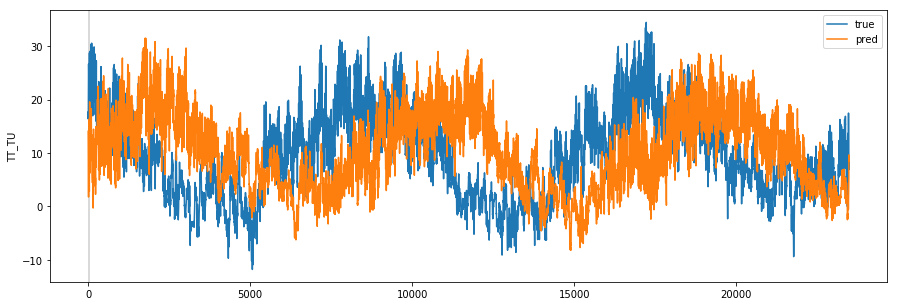

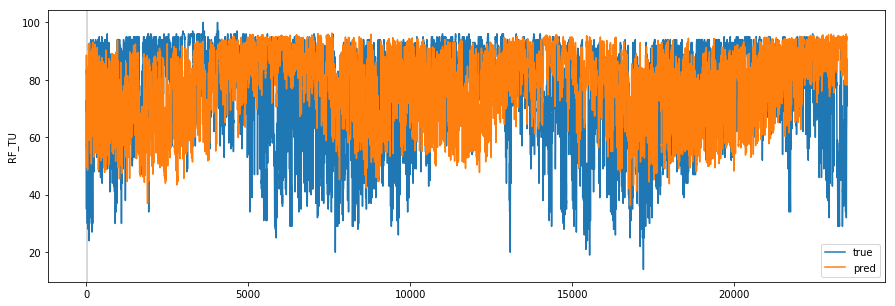

In [33]:
plot_comparison(start_idx=0, length=23477, train=True)

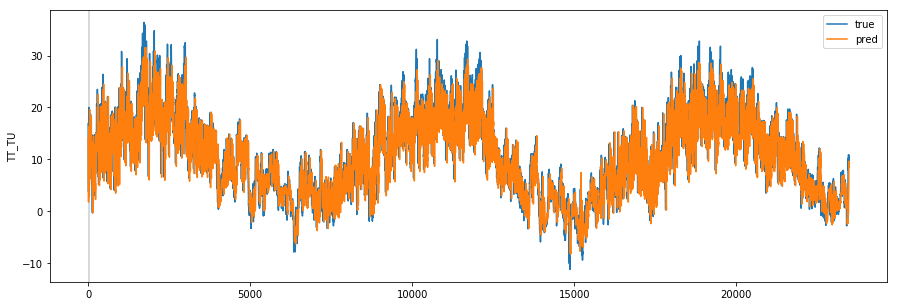

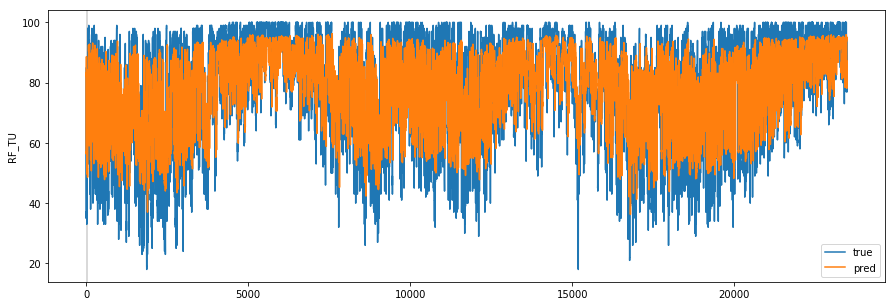

In [34]:
plot_comparison(start_idx=0, length=23477, train=False)

From the graphs above, we can see that prediction is much more better on test set than training set.